### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle
from WeightedLDA import WeightedLDA
from shapeGMMTorch import similarities 
from shapeGMMTorch import plots

### load trajectory

In [2]:
data_path = "./"

# select atoms
sel_atoms = "(name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)"
print("selected atoms:", sel_atoms)

prmtopFileName =  data_path + "left_protein_only.gro"
trajFiles = [data_path+"wt_metad_ld1_aib9_400K_height_0.005_bf_2.0_wrapped_500ns.xtc"]
print(trajFiles)

coord = md.Universe(prmtopFileName,trajFiles)
bb_atoms = coord.select_atoms(sel_atoms)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",bb_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,bb_atoms.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = bb_atoms.positions - bb_atoms.center_of_geometry()
    count += 1

selected atoms: (name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)
['./wt_metad_ld1_aib9_400K_height_0.005_bf_2.0_wrapped_500ns.xtc']
Number of atoms in trajectory: 129
Number of frames in trajectory: 500001
Number of atoms being analyzed: 23
Number of frames being analyzed: 500001


### load from COLVAR

In [3]:
time, ld1, metad_rbias = np.loadtxt(data_path+"COLVAR", usecols=(0,1,3), unpack=True)
time *= 1e-3 # in ns
zeta = np.loadtxt(data_path+"zeta.txt")


wall_bias = np.sum(np.loadtxt(data_path+"COLVAR", usecols=(-2,-1)), axis=1)

### plot the bias 

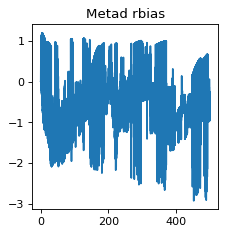

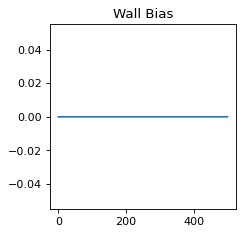

In [4]:
plt.figure(figsize=(3,3), dpi=80)
plt.title("Metad rbias", fontsize=12)
plt.plot(time, metad_rbias)

plt.figure(figsize=(3,3), dpi=80)
plt.title("Wall Bias", fontsize=12)
plt.plot(time, wall_bias)

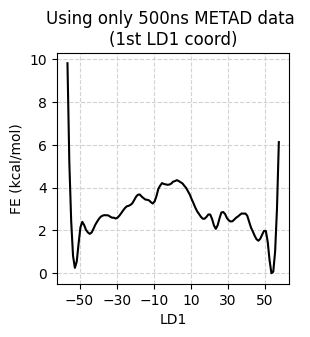

In [5]:
kbt = 0.794882 # from PLUMED at 400.0K
num_bins = 120
range_ = [-60,60]

# histogram
hist, edges = np.histogram(ld1, bins=num_bins, range=range_, density=True, weights=np.exp(metad_rbias/kbt))
bins = (edges[1:]+edges[:-1])/2
fe = -kbt*np.log(hist)
fe -= fe.min()

# plot
plt.figure(figsize=(3,3))
plt.title("Using only 500ns METAD data \n(1st LD1 coord)")
plt.ylabel("FE (kcal/mol)")
plt.xticks(np.arange(-50,70, 20))
plt.xlabel("LD1")
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.plot(bins, fe, 'k-')

### plot LD and $\zeta$

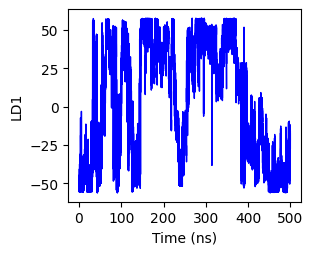

In [6]:
plt.figure(figsize=(3,2.5))
plt.xticks(np.arange(0,600,100))
plt.xlabel("Time (ns)")
plt.ylabel("LD1")
plt.plot(time, ld1, 'b-', lw=1.0)

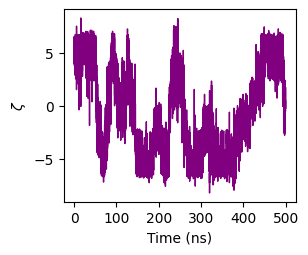

In [7]:
plt.figure(figsize=(3,2.5))
plt.xticks(np.arange(0,600,100))
plt.xlabel("Time (ns)")
plt.ylabel("$\zeta$")
plt.plot(time, zeta, ls="-", color="purple", lw=1.0)

### select the data and calculate weights

In [8]:
stride_ = 5  ## every 5 frame

trajData = trajData[::stride_,:,:]
time = time[::stride_]
metad_rbias = metad_rbias[::stride_]
ld1 = ld1[::stride_]
zeta = zeta[::stride_]

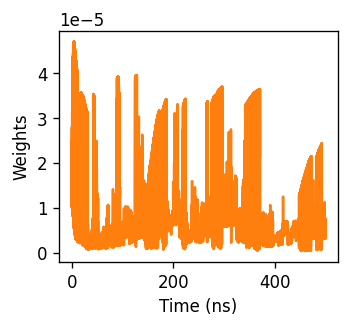

In [9]:
kt = 0.794882 # from PLUMED at 400.0K
weights = np.exp(metad_rbias/kt)  ## wall_bias = 0.0 for all chosen frames i.e. why not included
weights /=  np.sum(weights)

plt.figure(figsize=(3,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights, '-', color="tab:orange")

### perform cluster scan 

In [10]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)
print(cluster_array)

[2 3 4 5 6 7]


In [9]:
# perform cluster scan on this data (use 90% data for training)
#train, cv = scripts.cross_validate_cluster_scan(trajData, 90000, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 90000
Number of frames to predict each model: 10001
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               2               1              90.657          46.776
              1               2               2              88.164          17.783
              1               2               3              84.503           9.142
              1               2               4              90.601          49.362
              1               2               5              90.955          37.334
              1               2               6              88.166          13.520
              1               2               7              86.913          24.276
              1               2               8              90.7

              2               5               5             101.253          46.855
              2               5               6             100.619          64.701
              2               5               7             100.796          25.865
              2               5               8             100.962          70.853
              2               5               9             101.089          34.111
              2               5              10             100.024          41.592
              2               6               1             103.715          81.158
              2               6               2             102.991          59.540
              2               6               3             102.594          38.776
              2               6               4             103.669          34.725
              2               6               5             102.594          56.461
              2               6               6             101.685         

              4               3               3              95.767          14.640
              4               3               4              95.797          31.701
              4               3               5              95.464          44.743
              4               3               6              95.555          56.427
              4               3               7              92.691          17.014
              4               3               8              89.050          17.655
              4               3               9              94.279          41.253
              4               3              10              93.993          15.646
              4               4               1              99.342          35.649
              4               4               2              99.274          29.495
              4               4               3              97.135          46.219
              4               4               4              99.182         

In [11]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

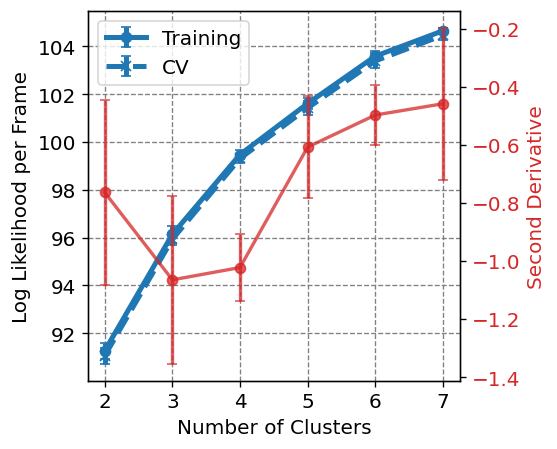

In [12]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plots.plot_log_likelihood_with_dd(ax,cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=True, xlabel=True)

## 3 clusters

In [13]:
#wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_3states.pickle", "wb")as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              94.935         510.024
       2              95.529         381.871
       3              96.149         399.672
       4              96.011         349.701
       5              94.455         304.172
       6              95.666         345.609
       7              96.095         385.407
       8              95.513         450.084
       9              96.049         344.768
      10              94.909         427.571
      11              95.089         434.607
      12              92.346         200.323
      13              95.498         156.138
      14              96.051         342.438
      15              93.894         348.655
      16              95.677         375.338
      17              95.916         409.331
      18              94.738         517.899
      19       

## 4 clusters

In [14]:
#wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_4states.pickle", "wb")as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              99.295         389.423
       2              99.235         509.325
       3              97.464         140.754
       4              99.094         442.813
       5              97.619         329.369
       6              99.174         534.913
       7              97.628         442.199
       8              99.274         390.630
       9              98.597         404.859
      10              99.403         537.368
      11              99.644         403.397
      12              98.482         435.180
      13              97.229         567.614
      14              99.358         358.563
      15              97.896         544.279
      16              99.150         375.977
      17              97.656         216.097
      18              99.103         422.440
      19       

### load all the objects 

In [13]:
wsgmm_list = []
for i in [3,4]:
    with open("wsgmm_%dstates.pickle"%i, "rb") as fo:
        wsgmm = pickle.load(fo)
    wsgmm_list.append(wsgmm)

In [14]:
print(wsgmm_list[0].weights)
print(wsgmm_list[0].cluster_ids.shape)

[0.42013115 0.31640191 0.26346694]
(100001,)


### Check the bhattacharya distances for cluster centers w.r.t. initial clusters

$\textbf{load initial object from wt-metad of posLDA paper}$

c= 0 is left helix and c= 1 is right helix.

In [15]:
path_to_ref_gmm = "/scratch/projects/hockygroup/ss12902/aib9_sGMM_torch/"
with open(path_to_ref_gmm+"wsgmm.pickle", "rb") as fo:
    wsgmm_ref = pickle.load(fo)

In [16]:
dist_data = []

# loop over objects [3,4]
for i in range(2):
    
    vals = []
    # loop over number of clusters
    for j in range(wsgmm_list[i].n_clusters):
        
        # wrt 0
        dij_0 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 0)
        
        # wrt 1
        dij_1 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 1)
        
        vals.append([dij_0, dij_1])
        
    #dist_data.append(np.array(vals))
    dist_data.append(np.log(np.array(vals)))     # take log y

In [17]:
print(dist_data)

[array([[6.33119214, 0.733879  ],
       [1.15550474, 5.8542002 ],
       [2.46327672, 2.30562821]]), array([[6.66286906, 0.05386594],
       [0.10514383, 6.80124008],
       [2.43812526, 2.39970227],
       [2.07579881, 2.00711893]])]


In [18]:
print(dist_data[0].shape)

(3, 2)


In [19]:
# save the log(B-dist) data
np.savetxt('logb-dist.txt', dist_data[0])

### 3 clusters

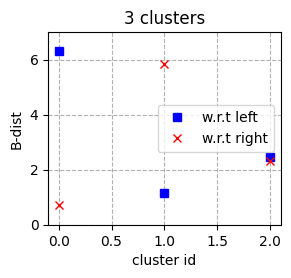

In [16]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("3 clusters")
plt.ylim(0,7)
wsgmm3 = wsgmm_list[0]
for i in range(wsgmm3.n_clusters):
    x = plt.plot(i, dist_data[0][i,0], 's', color="b", label="w.r.t left" if i == 0 else "")
    y = plt.plot(i, dist_data[0][i,1], 'x', color="r", label="w.r.t right" if i == 0 else "")
plt.legend()

-4.962151047132799
4.198307721090001
-0.9302461688987147


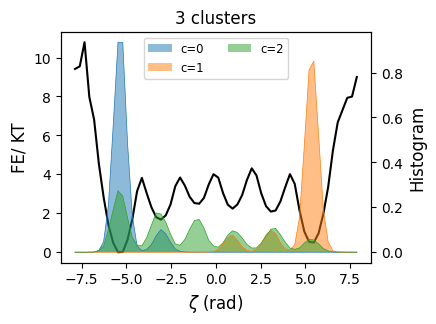

In [17]:
wsgmm3 = wsgmm_list[0]

range_ = [-8.0,8.0]
nbins = 60
hist, edges = np.histogram(zeta, range=range_, bins=nbins, density=True, weights=weights)
bins = (edges[1:]+edges[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()

fig, ax =plt.subplots(1, 1, figsize=(4,3))
plt.title("3 clusters")
ax.set_ylabel("FE/ KT", fontsize=12)
ax.set_xlabel("$\zeta$ (rad)", fontsize=12)
ax.plot(bins, fe, 'k-')
ax_inv  =ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    zeta_i = zeta[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]]
    print(np.mean(zeta_i))
    H, _ = np.histogram(zeta_i, range=range_, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]])
    ax_inv.fill_between(bins, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(bins, H, lw=0.5)
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

### 4 clusters

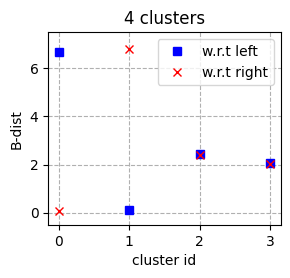

In [18]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("4 clusters")
plt.ylim(-0.5,7.5)
wsgmm4 = wsgmm_list[1]
for i in range(wsgmm4.n_clusters):
    x = plt.plot(i, dist_data[1][i,0], 's', color="b", label="w.r.t left" if i == 0 else "")
    y = plt.plot(i, dist_data[1][i,1], 'x', color="r", label="w.r.t right" if i == 0 else "")
plt.legend()

-5.3672852091865995
5.3408488525210105
-0.17618598460933502
-0.5179986471627185


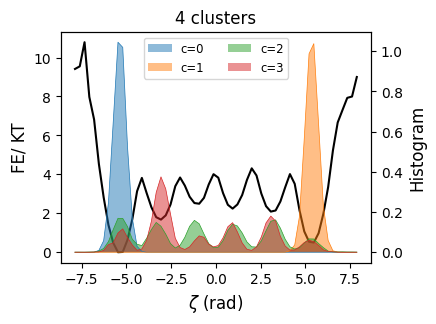

In [19]:
wsgmm4 = wsgmm_list[1]

range_ = [-8.0,8.0]
nbins = 60
hist, edges = np.histogram(zeta, range=range_, bins=nbins, density=True, weights=weights)
bins = (edges[1:]+edges[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()

fig, ax =plt.subplots(1, 1, figsize=(4,3))
plt.title("4 clusters")
ax.set_ylabel("FE/ KT", fontsize=12)
ax.set_xlabel("$\zeta$ (rad)", fontsize=12)
ax.plot(bins, fe, 'k-')
ax_inv  =ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(4):
    zeta_i = zeta[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]]
    print(np.mean(zeta_i))
    H, _ = np.histogram(zeta_i, range=range_, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]])
    ax_inv.fill_between(bins, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(bins, H, lw=0.5)
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

### Global Alignment of trajectory 

In [20]:
# load the global aligned traj -->
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)
print(global_aligned_traj.shape)

(100001, 23, 3)


### We are going to choose 3-state fit 

For 3 clusters ->
1. c=0 is closest to right state
2. c=1 is closest to left state 

In [21]:
c0_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 0)]   # right 
c1_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 1)]   # left 
c2_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 2)]  

print(len(c0_indx), len(c1_indx), len(c2_indx))

24676 24006 51319


In [22]:
c0_traj = global_aligned_traj[c0_indx,:,:]   # close to right
c1_traj = global_aligned_traj[c1_indx,:,:]   # close to left

comb_traj = np.concatenate([c1_traj, c0_traj], axis=0)
labels = np.concatenate([np.zeros(len(c1_indx)), np.ones(len(c0_indx))], axis=0)

print(comb_traj.shape, labels.shape)

(48682, 23, 3) (48682,)


### perform weighted LDA 

In [23]:
from WeightedLDA import WeightedLDA as WL

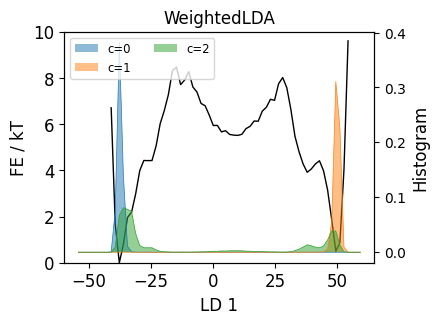

In [24]:
ld_range = (-55,60)
nbins = 70

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
ax.set_ylabel("FE / kT",fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_ylim(0,10.0)

# lda calculation
lda = WL.WeightedLDA()

# get weights for left and right helix only
sel_weights = np.concatenate([weights[c1_indx], weights[c0_indx]], axis=0)

lda.fit(comb_traj.reshape(comb_traj.shape[0], comb_traj.shape[1]*3), labels, wgts=sel_weights)
ld1_all = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=weights)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.0, color="k")

ax_inv = ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    ld_i = ld1_all[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]]
    H, _ = np.histogram(ld_i, range=ld_range, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper left", fontsize="small")

In [25]:
print(kt)
print(max(ld1_all), min(ld1_all))

0.794882
53.66648694887491 -41.21328192427134


In [26]:
# save the lda coefficients
#np.savetxt("ld1_3states_scalings.txt", lda.scalings_[:,0])

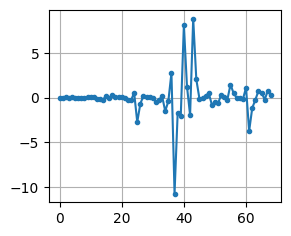

In [27]:
plt.figure(figsize=(3,2.5))
plt.grid()
plt.plot(lda.scalings_[:,0], '.-')

In [28]:
# calculating the standard deviation

print(np.std(ld1_all[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == 1)]])/2)

0.5672786690383183


In [29]:
print(bb_atoms.indices+1)

[ 18  20  22  31  33  35  44  46  48  57  59  61  70  72  74  83  85  87
  96  98 100 109 111]


## The entire part below is very recent (dated: 11th Feb, 2025)

In [30]:
c0_frames = trajData[c0_indx]   # close to right
c1_frames = trajData[c1_indx]   # close to left
c2_frames = trajData[c2_indx]  

print(c0_frames.shape, c1_frames.shape, c2_frames.shape)

(24676, 23, 3) (24006, 23, 3) (51319, 23, 3)


In [31]:
c0_wgts = weights[c0_indx]
c1_wgts = weights[c1_indx]
c2_wgts = weights[c2_indx]

In [32]:
print(np.sum(weights))
print(np.sum(c0_wgts), np.sum(c1_wgts), np.sum(c2_wgts))

0.9999999999999999
0.4198080134967739 0.3163090039577512 0.26388298254547493


### check the distribution of weights for frames belonging to left and right

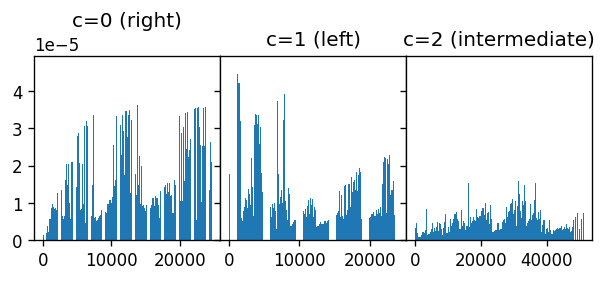

In [33]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6,2), dpi=120)

axs[0].set_title('c=0 (right)')
axs[0].bar(np.arange(len(c0_wgts)), c0_wgts)

axs[1].set_title('c=1 (left)')
axs[1].bar(np.arange(len(c1_wgts)), c1_wgts)

axs[2].set_title('c=2 (intermediate)')
axs[2].bar(np.arange(len(c2_wgts)), c2_wgts)

plt.subplots_adjust(wspace=0)
#fig.tight_layout()

### 1. Implement equal weights to both left and right clusters before use in LDA

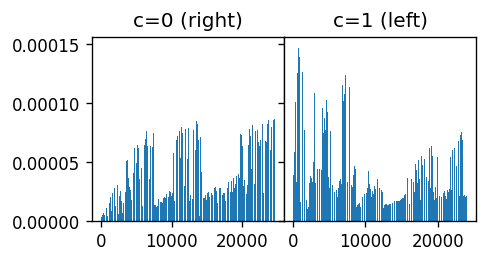

In [34]:
c0_wgts_modf = c0_wgts/np.sum(c0_wgts)
c1_wgts_modf = c1_wgts/np.sum(c1_wgts)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(4,2), dpi=120)

axs[0].set_title('c=0 (right)')
axs[0].bar(np.arange(len(c0_wgts)), c0_wgts_modf)

axs[1].set_title('c=1 (left)')
axs[1].bar(np.arange(len(c1_wgts)), c1_wgts_modf)

fig.subplots_adjust(wspace=0, left=0.1)

In [35]:
print(np.sum(c0_wgts_modf), np.sum(c1_wgts_modf))

1.0 1.0


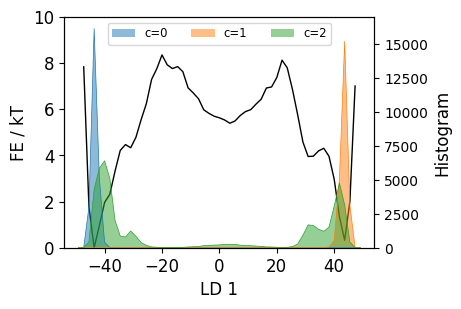

In [36]:
ld_range = (-50,50)
nbins = 55

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

#ax.set_title("WeightedLDA", fontsize=12)
ax.set_ylabel("FE / kT",fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_ylim(0,10.0)

# lda calculation
lda = WL.WeightedLDA()

# Note here we are using modified weights
sel_weights = np.concatenate([c1_wgts_modf, c0_wgts_modf], axis=0)

lda.fit(comb_traj.reshape(comb_traj.shape[0], comb_traj.shape[1]*3), labels, wgts=sel_weights)
ld1_all = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=weights)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.0, color="k")

ax_inv = ax.twinx()
ax_inv.set_ylim(0, 17000)
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]
    ld_i = ld1_all[indx]
    #H, _ = np.histogram(ld_i, range=ld_range, bins=nbins, density=True, weights=weights[indx])
    H, _ = np.histogram(ld_i, range=ld_range, bins=nbins)

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=3, loc="upper center", fontsize="small")

In [37]:
print(min(ld1_all), max(ld1_all))

-47.23268656409937 47.79409626475925


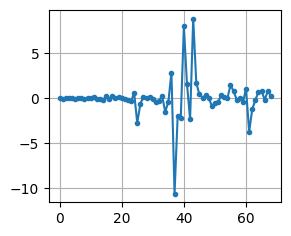

In [38]:
plt.figure(figsize=(3,2.5))
plt.grid()
plt.plot(lda.scalings_[:,0], '.-')

In [135]:
# save the new lda coefficients
#np.savetxt('ld1_scalings_equal_wgts.txt', lda.scalings_[:,0])

### 2. Another approach: We calaculate the global mean and convariance by the alignemnt of left/rigth frames only

### equal weights

In [39]:
comb_frames = np.concatenate([c1_frames, c0_frames])
comb_wgts = np.concatenate([c1_wgts_modf, c0_wgts_modf])  # equal wgts 

In [42]:
print(avg.shape, prec.shape, lpdet, aligned_traj.shape)

torch.Size([23, 3]) torch.Size([23, 23]) tensor(-87.7186, dtype=torch.float64) torch.Size([48682, 23, 3])


In [40]:
# now load the data 
aligned_traj = np.load('aligned_traj_equal_wgts.npy', allow_pickle=True)
full_aligned_traj = np.load('full_aligned_traj_equal_wgts_test.npy', allow_pickle=True)
#full_aligned_traj = np.load('full_aligned_traj_equal_wgts.npy', allow_pickle=True)

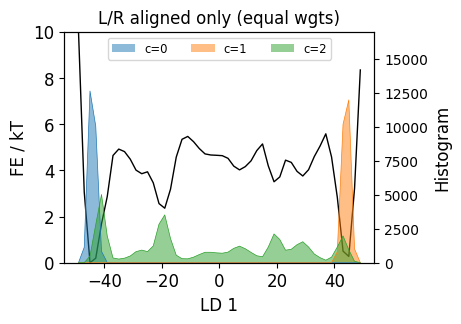

In [41]:
ld_range = (-50,50)
nbins = 50

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title('L/R aligned only (equal wgts)')
ax.set_ylabel("FE / kT",fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_ylim(0,10.0)

# lda calculation
lda = WL.WeightedLDA()

lda.fit(aligned_traj.reshape(aligned_traj.shape[0], aligned_traj.shape[1]*3), labels, wgts=comb_wgts)
ld1_all = lda.transform(full_aligned_traj.reshape(full_aligned_traj.shape[0], full_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=weights)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.0, color="k")

ax_inv = ax.twinx()
ax_inv.set_ylim(0, 17000)
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]
    ld_i = ld1_all[indx]
    #H, _ = np.histogram(ld_i, range=ld_range, bins=nbins, density=True, weights=weights[indx])
    H, _ = np.histogram(ld_i, range=ld_range, bins=nbins)

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=3, loc="upper center", fontsize="small")

In [42]:
print(min(ld1_all), max(ld1_all))
#np.savetxt('test_data.txt', ld1_all)

-48.46035372029134 50.66564212002205


In [213]:
#np.savetxt('ld1_coeff_aligned_equal_wgts.txt', lda.scalings_[:,0])

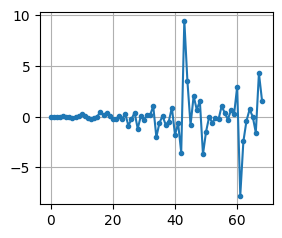

In [43]:
plt.figure(figsize=(3,2.5))
plt.grid()
plt.plot(lda.scalings_[:,0], '.-')

### not equal weights

In [44]:
print(np.sum(c1_wgts), np.sum(c0_wgts))

0.3163090039577512 0.4198080134967739


In [46]:
comb_frames = np.concatenate([c1_frames, c0_frames])
comb_wgts = np.concatenate([c1_wgts, c0_wgts])  # not equal wgts

In [47]:
from shapeGMMTorch import torch_align

traj_tensor = torch.tensor(comb_frames, dtype=torch.float)
wgts_tensor = torch.tensor(comb_wgts)

# calculate aligned traj, avg, prec
aligned_traj, avg, prec, lpdet = \
torch_align.torch_iterative_align_kronecker_weighted(traj_tensor, wgts_tensor, device=torch.device("cpu"), max_iter=500)

In [48]:
print(avg.shape, prec.shape, lpdet, aligned_traj.shape)

torch.Size([23, 3]) torch.Size([23, 23]) tensor(-87.9396, dtype=torch.float64) torch.Size([48682, 23, 3])


In [49]:
# now use this avg and prec to align the whole trajectory 
full_aligned_traj = torch_align.torch_align_kronecker\
(torch.tensor(trajData, dtype=torch.float), ref_tensor=avg, precision_tensor=prec, device=torch.device("cpu"))

np.save('full_aligned_traj_not_equal_wgts_test.npy', full_aligned_traj, allow_pickle=True)

In [50]:
print(full_aligned_traj.shape)

torch.Size([100001, 23, 3])


In [51]:
# now load the data 
aligned_traj = np.load('aligned_traj_not_equal_wgts.npy', allow_pickle=True)
full_aligned_traj = np.load('full_aligned_traj_not_equal_wgts_test.npy', allow_pickle=True)

#full_aligned_traj = np.load('full_aligned_traj_not_equal_wgts.npy', allow_pickle=True)

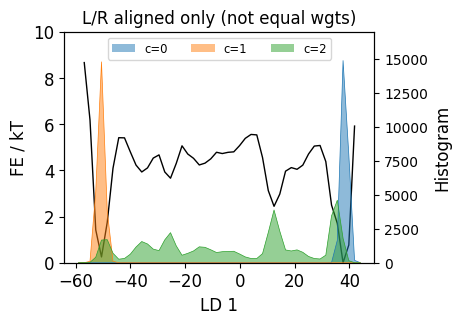

In [56]:
ld_range = (-60,45)
nbins = 50

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title('L/R aligned only (not equal wgts)')
ax.set_ylabel("FE / kT",fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_ylim(0,10.0)

# lda calculation
lda = WL.WeightedLDA()

lda.fit(aligned_traj.reshape(aligned_traj.shape[0], aligned_traj.shape[1]*3), labels, wgts=comb_wgts)
ld1_all = lda.transform(full_aligned_traj.reshape(full_aligned_traj.shape[0], full_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=weights)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.0, color="k")

ax_inv = ax.twinx()
ax_inv.set_ylim(0, 17000)
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]
    ld_i = ld1_all[indx]
    #H, _ = np.histogram(ld_i, range=ld_range, bins=nbins, density=True, weights=weights[indx])
    H, _ = np.histogram(ld_i, range=ld_range, bins=nbins)

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=3, loc="upper center", fontsize="small")

In [57]:
print(min(ld1_all), max(ld1_all))

-57.88334506577953 42.29429190902636


In [184]:
#np.savetxt('ld1_coeff_aligned_not_equal_wgts.txt', lda.scalings_[:,0])

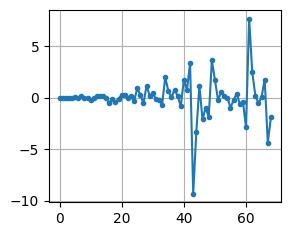

In [58]:
plt.figure(figsize=(3,2.5))
plt.grid()
plt.plot(lda.scalings_[:,0], '.-')

In [72]:
x = np.std(ld1_all[:400:])
print(x/3)

0.6066595083433137


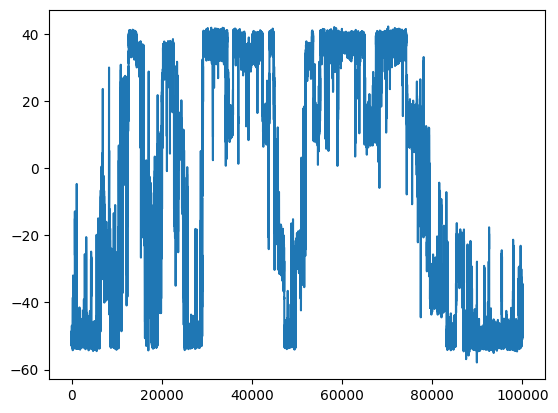

In [69]:
plt.plot(ld1_all)